In [1]:
import gym
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import deque
from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"

# MountainCar-V0

В данном задании было необходимо решить среду MountainCar, в которой предлагается использовать дискретные действия, а в качестве состояния используется положение машинки по оси X и ее скорость.

Подобные среды (обычно) легко решаются с помощью стадартного Q-learning'a, даже и без нейронных сетей, а просто с помощью таблички и дискретезации пространства состояний. В тестовом я решил использовать DQN, чтобы лишний раз попрактиковаться в чуть более сложных подходах. DQN славится нестабильностью обучения и это видно по графикам, поэтому требуется осторожно подбирать гиперпараметры даже на такой простой среде.

В коде написан стандартный алгоритм DQN, использующей в качестве функции ошибки mean-squared Bellman error (MSBE), а выучивает оценку Q функции для произвольного состояния.

Для ускорения обучения использовался метод reward shaping или метод потенциалов. С помощью него можно безопасно (не изменив задачу) сделать положительную награду более частой.

Решением считается награда выше или равная -110.

In [1]:
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)
        
    def add(self, transition):
        self.buffer.append(transition)
        
    def sample(self, size):
        batch = random.sample(self.buffer, size)
        return list(zip(*batch))

In [2]:
class DQN:
    def __init__(self, state_size, action_size, gamma=0.99, lr=1e-3):
        self.gamma = gamma
        
        self.model = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_size)
        )
        self.target_model = deepcopy(self.model)
        
        self.model.to(device)
        self.target_model.to(device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def dqn_loss(self, state, action, reward, next_state, done):
        target = reward + self.gamma * (1 - done) * self.target_model(next_state).max(dim=-1).values
        
        q = self.model(state)[torch.arange(len(action)), action]
    
        return F.mse_loss(q, target)
    
    def update_target(self):
        self.target_model = deepcopy(self.model)
        self.target_model.to(device)
    
    def act(self, state):
        state = torch.tensor(state, device=device, dtype=torch.float32)
        action = torch.argmax(self.model(state), dim=-1)
        
        return action.cpu().numpy().item()
        
    def update(self, batch):
        state, action, reward, new_state, done = batch
        
        state = torch.tensor(state, device=device, dtype=torch.float32)
        action = torch.tensor(action, device=device, dtype=torch.long)
        reward = torch.tensor(reward, device=device, dtype=torch.float32)
        new_state = torch.tensor(new_state, device=device, dtype=torch.float32)
        done = torch.tensor(done, device=device, dtype=torch.float32)
        
        loss = self.dqn_loss(state, action, reward, new_state, done)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss

In [3]:
def rollout(env, model):
    total_reward = 0.0
    done, state = False, env.reset()
    
    while not done:
        action = model.act(state)
        
        state, reward, done, _ = env.step(action)
        total_reward += reward
    
    return total_reward

def evaluate_model(model, episodes=10):
    env = gym.make("MountainCar-v0")
    env.seed(0) 
    
    rewards = []
    
    for _ in range(episodes):
        rewards.append(rollout(env, model))
    
    return np.mean(rewards), np.std(rewards)

def train(model, timesteps=500_000, start_train=10_000, buffer_size=100_000, \
                 batch_size=512, target_update=1000, test_every=5000, max_eps=0.5, min_eps=0.0):
    env = gym.make("MountainCar-v0")
    
    env.seed(0)
    env.action_space.seed(0)
    random.seed(0)
    
    reward_means, reward_std = [], []
    
    buffer = ReplayBuffer(size=buffer_size)
    done, state = False, env.reset()

    for step in range(timesteps):
        if done:
            done, state = False, env.reset()
        
        eps = max_eps - ((max_eps - min_eps) * step / timesteps)

        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = model.act(state)
            
        new_state, reward, done, _ = env.step(action)
        reward = reward + 300 * (model.gamma * abs(new_state[1]) - abs(state[1]))
        
        buffer.add((state, action, reward, new_state, int(new_state[0] >= 0.5)))
        
        state = new_state
        
        if step >= start_train:
            model.update(buffer.sample(size=batch_size))
            
        if step % target_update == 0:
            model.update_target()
        
        if step % test_every == 0 or step == timesteps - 1:
            mean, std = evaluate_model(model, episodes=10)
            
            reward_means.append(mean)
            reward_std.append(std)
            
            print(f"Step: {step}, Mean reward: {mean:.2f}, std: {std:.2f}, eps: {eps:.3f}")
            
    return np.array(reward_means), np.array(reward_std)

# Обучение агента

In [53]:
dqn_model_eps = DQN(state_size=2, action_size=3, gamma=0.99, lr=1e-3)

means, stds = train(dqn_model_eps, max_eps=0.2, timesteps=200_000, start_train=10_000, 
                   buffer_size=100_000, batch_size=128, target_update=1000, test_every=5000)

Step: 0, Mean reward: -200.00, std: 0.00, eps: 0.200
Step: 5000, Mean reward: -200.00, std: 0.00, eps: 0.195
Step: 10000, Mean reward: -200.00, std: 0.00, eps: 0.190
Step: 15000, Mean reward: -121.20, std: 22.36, eps: 0.185
Step: 20000, Mean reward: -128.30, std: 19.09, eps: 0.180
Step: 25000, Mean reward: -157.60, std: 20.11, eps: 0.175
Step: 30000, Mean reward: -172.80, std: 10.47, eps: 0.170
Step: 35000, Mean reward: -167.60, std: 30.44, eps: 0.165
Step: 40000, Mean reward: -188.30, std: 17.89, eps: 0.160
Step: 45000, Mean reward: -157.60, std: 28.14, eps: 0.155
Step: 50000, Mean reward: -122.30, std: 4.34, eps: 0.150
Step: 55000, Mean reward: -119.70, std: 31.41, eps: 0.145
Step: 60000, Mean reward: -143.70, std: 31.97, eps: 0.140
Step: 65000, Mean reward: -131.20, std: 20.68, eps: 0.135
Step: 70000, Mean reward: -196.30, std: 10.45, eps: 0.130
Step: 75000, Mean reward: -166.10, std: 34.78, eps: 0.125
Step: 80000, Mean reward: -169.20, std: 31.02, eps: 0.120
Step: 85000, Mean rewar

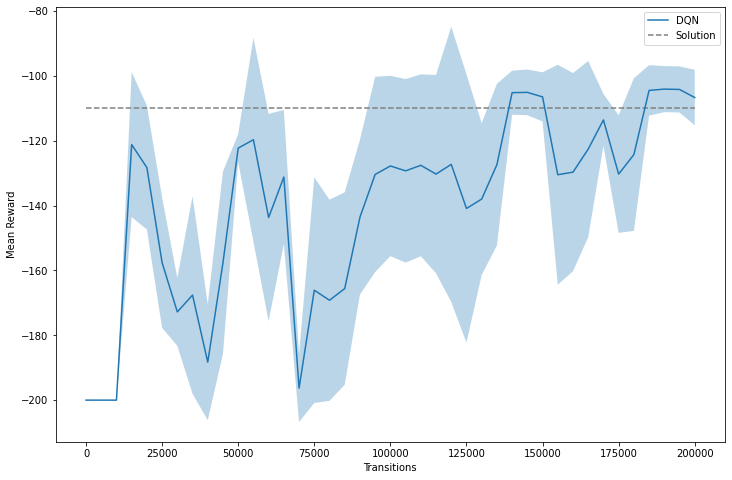

In [54]:
x = np.arange(len(means)) * 5000

plt.figure(figsize=(12, 8))
plt.hlines(-110, 0, np.max(x), linestyles="dashed", color="grey", label="Solution")
plt.plot(x, means, label="DQN")
plt.fill_between(x, means - stds, means + stds, alpha=0.3)
plt.ylabel("Mean Reward")
plt.xlabel("Transitions")
plt.legend();